In [134]:
import re
import patsy
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from utils.EDA.analysis import *
import warnings

In [135]:
# report 확인
def LinearRegR(data, formula):
    model = sm.OLS.from_formula(formula, data)
    result = model.fit()
    print(result.summary())
    return result
    

def plot_pre_tar(result, data, tar):
    predict = result.predict(data).values

    target = data[tar].values
    plt.scatter(target, predict)
    
    return result
    
# 예측치와 추정치 결과 확인 (위치도 출력)
# plot_leverage_resid2, influence_plot 확인
def LinearReg(data, formula):
    model = sm.OLS.from_formula(formula, data)
    result = model.fit()
    
    predict = result.predict(data).values

    y = formula.split("~")[0].strip()
    target = data[y].values
    plt.scatter(target, predict)
    
    return result
    
    
def LinearRegO(data, formula, num_param):
    model = sm.OLS.from_formula(formula, data)
    result = model.fit()
    
    predict = result.predict(data).values

    y = formula.split("~")[0].strip()
    target = data[y].values

#     ax = plt.subplot()
#     plt.scatter(target, predict)
#     cook_d2, pvals = result.get_influence().cooks_distance
#     fox_cr = 4 / (len(y) - num_param)
#     idx = np.where(cook_d2 > fox_cr)[0]
#     plt.scatter(target[idx], predict[idx], s=300, c="r", alpha=0.5)
#     utils.annotate_axes(range(len(idx)), idx, 
#                     list(zip(target[idx], predict[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
    
    
    sm.graphics.influence_plot(result)
    
def plot_Exo(result, column_list):
    
    for c in columns_list:
        fig = sm.graphics.plot_regress_exog(result, c)
        fig.set_size_inches(10, 10)
# 그래프 보기( 잔차 ) / 컬럼 값이 입력
# plot_regress_exog(fitting plit, residal-x, partial, CCPR)

In [136]:
def makeFormula(target, numeric=None, categoric=None, noInter = False, scale = False):
    formula = ""
    formula += target
    formula += "~"
    
    if(numeric != None):
        if scale == True:
            numeric = list(map(lambda c :  "scale(" + c + ")", numeric))
        formula_numeric = "+".join(numeric)
        formula += formula_numeric 
    
    if(numeric != None or categoric != None):
        formula += "+"
    
    if(categoric != None):
        categoric = list(map(lambda c :  "C(" + c + ")", categoric))
        formula_categoric = "+".join(categoric)
        formula += formula_categoric
    
    if(noInter == True):
        formula +="+0"
    
    return formula

In [137]:
def makeFormula_scale(target, scale=None, non_scale=None, noInter=False):
    formula = ""
    formula += target
    formula += "~"
    
    if(scale != None):
        scale = list(map(lambda c :  "scale(" + c + ")", scale))
        formula_scale = "+".join(scale)
        formula += formula_scale 
    
    if(scale != None and non_scale != None):
        formula += "+"
    
    if(non_scale != None):
        formula_non_scale = "+".join(non_scale)
        formula += formula_non_scale
    
    if(noInter == True):
        formula +="+0"
    
    return formula

In [161]:
# Backward method
def backwarding_method(data, target, numeric_list, categoric_list, scale=False, debug = False):
    num_iter = 0
    isLoop = True
    
    while(isLoop):
        num_iter += 1
        column_list=[]
        if numeric_list != None:
            column_list += numeric_list
        if categoric_list != None:
            column_list += categoric_list
        
        if(scale == False):
            model = sm.OLS.from_formula(makeFormula_scale(target, None, column_list, True), data)
            result = model.fit()
        
        if(scale == True):
#             formula = makeFormula_scale(target, numeric_list, categoric_list, True)
#             print(formula)
#             model = sm.OLS.from_formula(formula, data)
            result = model.fit()

        pvalues = result.pvalues
        max_index = pvalues.sort_values(ascending = False).index[0]
        max_value = pvalues.sort_values(ascending = False).values[0]
        if  re.match(r'scale\((\w+)\)', max_index):
            max_index = re.sub(r"scale\((\w+)\)", r"\g<1>", max_index)
        
        if debug == True:
            print("{} 단계 : max_t_value : ({}, {}) \n".format(num_iter, max_index, max_value))

            print("현재 list : ", end = "")
            for c in column_list:
                print("{}, ".format(c), end = "")
            print("\n")
            
        if max_value > 0.01:
            if numeric_list != None:
                if max_index in numeric_list:
                    numeric_list.remove(max_index)
                    print("numeric")
                    
            if categoric_list != None:
                if max_index in categoric_list:
                    categoric_list.remove(max_index)
                    print("categoric")
                    
            isLoop = True
        else:
            isLoop = False
        
        
    print("{} 시도만에 작업 끝!! : 정제된 목록 리스트 ".format(num_iter))
    print("numeric list : ", numeric_list)
    print("categoric list : ", categoric_list)
    print()
    
    return numeric_list, categoric_list

In [139]:
def crossValidation(data, formula, split_num = 5, iter_num = 5, debug = False):
    rmsd_sum = 0
    r2_sum = 0
    num_iter=0
    
    for idx in range(iter_num):
        df_Y, df_X = patsy.dmatrices(formula, data=data, return_type='dataframe')
        df_cv_train_Y, df_cv_test_Y, df_cv_train_X, df_cv_test_X = train_test_split(df_Y, df_X, test_size=len(df_train)//split_num)

        model = sm.OLS(df_cv_train_Y, df_cv_train_X)
        result = model.fit()
        result.summary()

        predict = result.predict(df_cv_test_X).values[:, np.newaxis]
        target = df_cv_test_Y.values
        
        # get rmsd
        square_y = (predict - target) ** 2
        rmsd = np.sqrt(square_y.sum() / len(df_cv_test_Y))
        
        # get r2
        r2 = r2_score(target, predict)
        
        if debug == True:
            print("{}차 시도!!!".format(num_iter+1))
            print("rmsd : ", rmsd)
            print("r2 : ", r2)
            print()

        rmsd_sum += rmsd
        r2_sum += r2
        num_iter +=1
    
    print()
    rmsd_avr = rmsd_sum / iter_num
    r2_avr = r2_sum / iter_num
    print("rmsd_avr : ", rmsd_avr)
    print("test_r2 : ", r2_avr)

# read file

In [167]:
df_train = pd.read_csv("../data/train_dummy.csv")
df_test = pd.read_csv("../data/test_dummy.csv")

#get numeric data and categoric data
categoric_list = list(df_train.filter(regex="_").columns)
numeric_list = list(set(df_train.columns) - set(categoric_list))
numeric_list.remove("SalePriceLog")
numeric_list.remove("Id")

print(len(categoric_list), len(numeric_list), len(list(df_train.columns)))

318 124 444


# numeric data VIF확인

In [141]:
# df_X0 = df_train[numeric_list]
# df_vif = pd.DataFrame()
# df_vif["VIF Factor"] = [variance_inflation_factor(df_X0.values, i) for i in range(df_X0.shape[1])]
# df_vif["features"] = df_X0.columns

# df_vif.sort_values(by = "VIF Factor", ascending = False)

In [142]:
# # TotalBsmtSF 제거 (TotalBsmtSF, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF)
# column_list.remove("TotalBsmtSF")
# numeric_list.remove("TotalBsmtSF")

# # YearRemodel 제거 (나중에 했다 않했다로 생성)
# column_list.remove("YearRemodAdd")
# numeric_list.remove("YearRemodAdd")

# column_list.remove("log_GrLivArea")
# numeric_list.remove("log_GrLivArea")

In [191]:
# model = sm.OLS.from_formula(makeFormula_scale(target, ["OpenPorchSFpow2"], ["Condition1_Norm"], True), df_train)

In [192]:
# formula = makeFormula_scale(target, numeric_list, categoric_list, True)
# print(formula)
# model = sm.OLS.from_formula(str(formula), data)

# BackWarding method

In [193]:
# data=df_train
# target="SalePriceLog" 
# scale=True
# debug = False
# num_iter = 0
# isLoop = True

# while(isLoop):
#     num_iter += 1
#     column_list=[]
#     if numeric_list != None:
#         column_list += numeric_list
#     if categoric_list != None:
#         column_list += categoric_list

#     if(scale == False):
#         model = sm.OLS.from_formula(makeFormula_scale(target, None, column_list, True), data)
#         result = model.fit()

#     if(scale == True):
#         formula = makeFormula_scale(target, numeric_list, categoric_list, True)
#         model = sm.OLS.from_formula(formula, data)
#         result = model.fit()

#     pvalues = result.pvalues
#     max_index = pvalues.sort_values(ascending = False).index[0]
#     max_value = pvalues.sort_values(ascending = False).values[0]
#     if  re.match(r'scale\((\w+)\)', max_index):
#         max_index = re.sub(r"scale\((\w+)\)", r"\g<1>", max_index)

#     if debug == True:
#         print("{} 단계 : max_t_value : ({}, {}) \n".format(num_iter, max_index, max_value))

#         print("현재 list : ", end = "")
#         for c in column_list:
#             print("{}, ".format(c), end = "")
#         print("\n")

#     if max_value > 0.01:
#         if numeric_list != None:
#             if max_index in numeric_list:
#                 numeric_list.remove(max_index)
#                 print("numeric")

#         if categoric_list != None:
#             if max_index in categoric_list:
#                 categoric_list.remove(max_index)
#                 print("categoric")

#         isLoop = True
#     else:
#         isLoop = False


# print("{} 시도만에 작업 끝!! : 정제된 목록 리스트 ".format(num_iter))
# print("numeric list : ", numeric_list)
# print("categoric list : ", categoric_list)
# print()

# 결과 확인

In [179]:
model = sm.OLS.from_formula(makeFormula_scale("SalePriceLog", None, numeric_list+categoric_list, True), df_train)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           SalePriceLog   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     337.5
Date:                Sat, 10 Mar 2018   Prob (F-statistic):               0.00
Time:                        22:41:55   Log-Likelihood:                 1081.9
No. Observations:                1460   AIC:                            -2070.
Df Residuals:                    1413   BIC:                            -1821.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
OpenPorchSFpow2       -9.81e-07   3.56e-07     -2.754      0.006   -1.68e-06   -2.82e-07
YearBuiltpow2        -4.711e-05   1.02e-05     -4.622      0.000   -6.71e-05   -2.71e-05
LowQualFinSFpow3      8.755e-09   2.04e-09      4.291      0.000    4.75e-09    1.28e-08
YearRemodAddpow3      1.323e-10   2.01e-11      6.589      0.000    9.29e-11    1.72e-10
BsmtFinSF2pow2        1.342e-07   2.45e-08      5.481      0.000    8.62e-08    1.82e-07
LowQualFinSFpow2     -4.414e-06      1e-06     -4.397      0.000   -6.38e-06   -2.44e-06
FireplacesLog            0.0682      0.010      6.943      0.000       0.049       0.088
LotAreaLog               0.0798      0.008      9.993      0.000       0.064       0.095
FirstFlrSFpow2       -4.478e-08   1.43e-08     -3.129      0.002   -7.28e-08   -1.67e-08
SecondFlrSFpow3       2.675e-10    2.5e-11     10.719      0.000    2.19e-10    3.16e-10
OpenPorchSF              0.0003      0.000      3.007      0.003       0.000       0.001
GrLivAreapow3        -1.644e-11   1.25e-12    -13.120      0.000   -1.89e-11    -1.4e-11
GarageArea               0.0002   2.42e-05      6.801      0.000       0.000       0.000
KitchenAbvGrLog         -0.2648      0.039     -6.786      0.000      -0.341      -0.188
BsmtFinSF1               0.0002   1.21e-05     12.539      0.000       0.000       0.000
ScreenPorchpow2       7.535e-07   2.12e-07      3.559      0.000    3.38e-07    1.17e-06
GarageYrBlt           3.162e-05   9.03e-06      3.501      0.000    1.39e-05    4.93e-05
SecondFlrSFpow2      -4.288e-07   6.12e-08     -7.010      0.000   -5.49e-07   -3.09e-07
YearBuilt                0.0519      0.010      5.197      0.000       0.032       0.072
YearBuiltpow3         1.175e-08   2.61e-09      4.506      0.000    6.64e-09    1.69e-08
BsmtUnfSFpow3         2.475e-11   4.28e-12      5.783      0.000    1.64e-11    3.31e-11
GrLivArea                0.0006   3.43e-05     17.805      0.000       0.001       0.001
BsmtCond_TA              0.0327      0.011      3.033      0.002       0.012       0.054
BsmtQual_Ex              0.0489      0.015      3.176      0.002       0.019       0.079
CentralAir_N            -0.0313      0.008     -4.002      0.000      -0.047      -0.016
CentralAir_Y             0.0314      0.008      4.012      0.000       0.016       0.047
Condition1_Norm          0.0497      0.010      5.169      0.000       0.031       0.069
Condition1_RRAe         -0.1020      0.037     -2.751      0.006      -0.175      -0.029
Exterior1st_BrkComm     -0.2392      0.089     -2.686      0.007      -0.414      -0.064
Foundation_PConc         0.0374      0.011      3.541      0.000       0.017       0.058
Functional_Maj2         -0.2033      0.055     -3.688      0.000      -0.311      -0.095
Functional_Typ           0.1003      0.014      7.423    

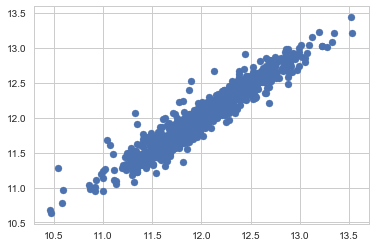

In [180]:
plot_pre_tar(result, df_train, "SalePriceLog")

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([-0.75252475, -0.73205478, -0.64135607, ...,  0.40014157,
          0.44754189,  0.47915337])),
 (0.1119210481612256, -6.2924627979632924e-08, 0.96854255708108361))

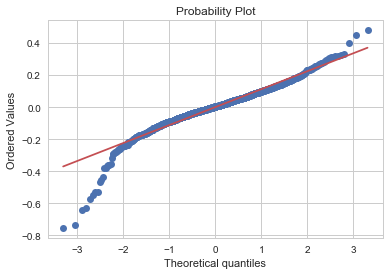

In [181]:
# 잔차의 정규성 확인
sp.stats.probplot(result.resid, plot =plt)

In [183]:
crossValidation(df_train, makeFormula_scale("SalePriceLog", None, numeric_list+categoric_list, True), 10, 100)


rmsd_avr :  0.123733276007
test_r2 :  0.902537406392


# make submit

In [182]:
##Test
df_test = pd.read_csv("../data/test_dummy.csv")

# 계산
y = result.predict(df_test)
y = np.exp(y)

# sumit 만들기
df_sumit = pd.DataFrame(columns = ["Id", "SalePrice"])
df_sumit["Id"] =df_test["Id"]
df_sumit["SalePrice"] = y

df_sumit.to_csv("../submit/submit.csv", index = False)